# RNN autoencoder

In [1]:
import numpy as np
from sent_dataset import SentenceDataset
from utils import prepare_sample

## Dataset

In [3]:
%%time
dataset = SentenceDataset(2, 32)
dataset.load('data/dostoevsky.txt', 10000000)  # dostoevsky.txt  anna.txt

CPU times: user 27.5 s, sys: 237 ms, total: 27.7 s
Wall time: 27.7 s


In [23]:
voc_size = dataset.num_tokens
sent_len = dataset.max_len+2

print("Sentences :", dataset.get_data_size())
print("Max length:", sent_len)
print("Vocabulary:", voc_size)
bos_token = dataset.word_to_token['<BOS>']
print(bos_token, dataset.token_to_word[bos_token])

Sentences : 111670
Max length: 34
Vocabulary: 104918
19479 <BOS>


## Model

In [54]:
import os
from utils import make_dir
import numpy as np
import tensorflow as tf
import pickle
from visualization import show_train_stats

class AutoencoderRNN:
    def __init__(self):
        self._scope    = 'autoencoder_rnn'
        # state
        self.tr_step   = 0
        self.tr_epoch  = 0
        self.tr_losses = []
        
    
    def _make_rnn_cell(self, num_units, num_layers, keep_prob):
        def make_layer():
            l = tf.contrib.rnn.BasicLSTMCell(num_units)
            l = tf.contrib.rnn.DropoutWrapper(l, output_keep_prob=keep_prob)
            return l        
        layers = [make_layer() for _ in range(num_layers)]
        cell   = tf.contrib.rnn.MultiRNNCell(layers)
        return cell

    
    def _make_loss(self, logits, labels):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits = logits,
            labels = labels)
        return tf.reduce_mean(loss)
    

    def _make_optimizer(self, loss, lr, grad_clip):
        tr_vars   = tf.trainable_variables()
        grads, _  = tf.clip_by_global_norm(tf.gradients(loss, tr_vars), grad_clip)
        train_op  = tf.train.AdamOptimizer(lr)
        optimizer = train_op.apply_gradients(zip(grads, tr_vars))
        return optimizer
    
    
    def _make_decoder(self, inp, h, num_units, num_layers, voc_size, seq_len, keep_prob):
        cell = self._make_rnn_cell(num_units, num_layers, keep_prob)
        logits_seq = []

        def loop_function(outputs):
            logits = tf.layers.dense(outputs, voc_size, name='projection')
            token = tf.argmax(logits, axis=1)
            inp = tf.nn.embedding_lookup(self.embedding, token)
            return inp, logits
            
        with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
            for t in range(seq_len):
                output, h = cell(inp, h)
                inp, logits = loop_function(output)
                logits_seq.append(tf.expand_dims(logits, 1))

        return tf.concat(logits_seq, 1)
    
    
    def build(self, voc_size, bos_token, emb_size, seq_len, num_units, num_layers, grad_clip=5):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default(), tf.variable_scope(self._scope):
            # placeholders
            self.enc_inputs_pl = tf.placeholder(tf.int32, [None, None], name='enc_inputs')
            self.targets_pl    = tf.placeholder(tf.int32, [None, None], name='targets')
            self.batch_size_pl = tf.placeholder(tf.int32, shape=[], name='batch_size')
            self.keep_prob_pl  = tf.placeholder(tf.float32, name='keep_prob')
            self.lr_pl         = tf.placeholder(tf.float32, name='learning_rate')

            # embedding
            self.embedding     = tf.Variable(tf.random_normal(shape=[voc_size, emb_size], dtype=tf.float32))
            en_inputs          = tf.nn.embedding_lookup(self.embedding, self.enc_inputs_pl)
            bos_tokens         = tf.tile([bos_token], tf.expand_dims(self.batch_size_pl,0))  
            de_inputs          = tf.nn.embedding_lookup(self.embedding, bos_tokens)
            
            # encoder
            en_cell            = self._make_rnn_cell(num_units, num_layers, self.keep_prob_pl)
            en_initial_state   = en_cell.zero_state(self.batch_size_pl, tf.float32)
            seq_lens           = tf.tile([seq_len], tf.expand_dims(self.batch_size_pl,0))
            _, en_state        = tf.nn.dynamic_rnn(en_cell, en_inputs, seq_lens, en_initial_state, scope='encoder')

            # decoder
            de_logits = self._make_decoder(
                inp        = de_inputs, 
                h          = en_state, 
                num_units  = num_units, 
                num_layers = num_layers,
                voc_size   = voc_size,
                seq_len    = seq_len, 
                keep_prob  = self.keep_prob_pl)

            # prediction
            self.outputs       = tf.argmax(tf.nn.softmax(de_logits), axis=2)

            # training
            self.loss_op       = self._make_loss(de_logits, self.targets_pl)
            self.train_op      = self._make_optimizer(self.loss_op, self.lr_pl, grad_clip)
            
            # utils
            self.init_op       = tf.global_variables_initializer()
            self._saver        = tf.train.Saver()

        # session
        self._sess = tf.Session(graph=self._graph)
        self._sess.run(self.init_op)
        
        
    def train(self, dataset, step_num,  batch_size, learning_rate, keep_prob=.5, log_every=20, mean_win=30):
        try:
            data_size = dataset.get_data_size()
            for self.tr_step in range(self.tr_step, step_num-1):
                ep = self.tr_step*batch_size/data_size
                sents = dataset.get_next_batch(batch_size)
                tr_loss, _ = self._sess.run(
                    [self.loss_op, self.train_op], 
                    feed_dict = {
                        self.enc_inputs_pl: sents,
                        self.targets_pl   : sents,
                        self.batch_size_pl: batch_size,
                        self.keep_prob_pl : keep_prob,
                        self.lr_pl        : learning_rate,
                })
                self.tr_losses.append(tr_loss)

                if self.tr_step % log_every == 0:
                    show_train_stats(ep, self.tr_step, self.tr_losses, mean_win)
                        
        except KeyboardInterrupt:
            show_train_stats(ep, self.tr_step, self.tr_losses, mean_win)
            

    def save(self, path):
        make_dir(path)
        pickle.dump([self.tr_epoch, self.tr_step, self.tr_losses], open(os.path.join(path, "state.p"), "wb"))
        self._saver.save(self._sess, path)
        
        
    def restore(self, path):
        try:
             [self.tr_epoch, self.tr_step, self.tr_losses] = pickle.load(open(os.path.join(path, "state.p"), "rb"))
        except: 
            print("State not found at", path)
        self._saver.restore(self._sess, path)
        
        
    def run(self, sents, batch_size, seq_length):
        return self._sess.run(
            self.outputs, 
            feed_dict = {
                self.enc_inputs_pl: sents,
                self.dec_inputs_pl: sents,
                self.targets_pl   : sents,
                self.batch_size_pl: batch_size,
                self.seq_length_pl: [seq_length, ]*batch_size,
                self.keep_prob_pl : 1,
        })


## Build

In [55]:
%%time
model_path = 'models/rnn_autoencoder/dostoevsky-001/'

model = AutoencoderRNN()

model.build(
    voc_size   = voc_size, 
    bos_token  = bos_token,
    seq_len    = sent_len,
    emb_size   = 100, 
    num_units  = 128, 
    num_layers = 2)

CPU times: user 6.83 s, sys: 530 ms, total: 7.36 s
Wall time: 6.74 s


## Train

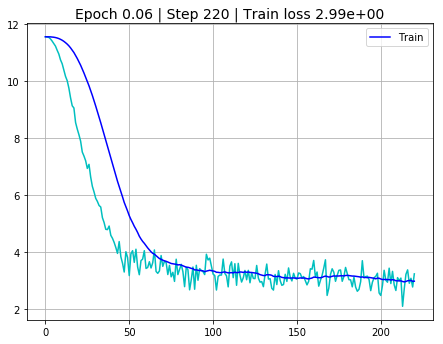

In [ ]:
%%time
model.train(
    step_num      = 100000,
    batch_size    = 32, 
    learning_rate = 1e-3, 
    mean_win      = 30,
    dataset       = dataset)
model.save(model_path)

## Test

In [17]:
batch_size = 10
inp = dataset.get_next_batch(batch_size)
out = model.run(inp, batch_size, sent_len)

def prepare(s):
    s = dataset.decode(s)
    s = s.replace('<BOS>', '[').replace('<EOS>', ']').replace(' _', '').replace(' ,', ',').replace(' !', '!').replace(' ?', '?').replace(' .', '.')
    return s
    
for i in range(len(inp)):
    print('-'*80)
    print(prepare(inp[i]))
    print(prepare(out[i]))


--------------------------------------------------------------------------------
[ наряд ее был грошовый, но разукрашенный по-уличному, под вкус и правила, сложившиеся в своем особом мире, с ярко и позорно выдающеюся целью. ]
[ птички ее был приказу, но вскакивал железных, под вкус и правила, проникновенно в своем ученье мире, с ярко и позорно биения целью. ]
--------------------------------------------------------------------------------
[ русскому читателю об этой вековечной правде слишком надо было напомнить многие стали у нас об ней забывать. ]
[ русскому читателю об этой бумажке правде слишком надо было напомнить многие стали у нас об ней забывать. ]
--------------------------------------------------------------------------------
[ — как уж известно вам, от единого страху-с. ]
[ — как уж известно вам, от единого простодушием. ]
--------------------------------------------------------------------------------
[ — вы в припадке, — сказал я, — вы трусите. ]
[ — вы в припадке, — сказал

## Restore

In [61]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/rnn_autoencoder/dostoevsky-001/
